---
title: Data Cleaning
bibliography: ../citations.bib
html:
    embed-resources: true
---

Now that we have gathered a reasonable amount of textual and record data, we can begin the data cleaning process. Our ultimate goal is to do statistical modeling wtih our data, so we need to clean the data. Generally, we will follow the principles of tidy data [@tidydata] in cleaning our data.

# Cleaning Text Data

To begin, we will clean our textual data by parsing out the text from the JSON and HTML objects that were returned from the Reddit and Wikipedia APIs respectively.

## Reddit Data

Recall that the Reddit data was returned as a JSON. We retrieved 10,000 text posts for each of three different text files. Our goal is to turn each of these JSON files into an individual dataframe. From there, we can transform the data into a Bag of Words, Document Term Matrix, or any other helpful format.

We will use `pandas` and `json` to parse this data into a desired output. First let's read in the data.

In [3]:
import pandas as pd
import json

with open("../data/raw_data/reddit_psychosis_data.json") as f:
    reddit_psychosis = json.load(f)
with open('../data/raw_data/reddit_cannabis_data.json') as f:
    reddit_cannabis = json.load(f)
with open("../data/raw_data/reddit_schizophrenia_data.json") as f:
    reddit_schizophrenia = json.load(f)

From the data pull, we know that each of these JSON files has 100 elements, each with 100 posts.

Let's look at the structure of one element to identify how we can extract the title and text information.

In [6]:
reddit_psychosis['0'].keys()

dict_keys(['kind', 'data'])

From here, we see that the posts are within the parameter `children`.

In [8]:
len(reddit_psychosis['0']['data']['children'])

dict_keys(['kind', 'data'])
100


It looks like these are the 100 posts we're looking for. Now we'll extract the title and text from each of these children elements.

In [9]:
reddit_psychosis['0']['data']['children'][1]['data'].keys()

dict_keys(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved', 'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext', 'subreddit_name_prefixed', 'hidden', 'pwls', 'link_flair_css_class', 'downs', 'thumbnail_height', 'top_awarded_type', 'hide_score', 'name', 'quarantine', 'link_flair_text_color', 'upvote_ratio', 'author_flair_background_color', 'subreddit_type', 'ups', 'total_awards_received', 'media_embed', 'thumbnail_width', 'author_flair_template_id', 'is_original_content', 'user_reports', 'secure_media', 'is_reddit_media_domain', 'is_meta', 'category', 'secure_media_embed', 'link_flair_text', 'can_mod_post', 'score', 'approved_by', 'is_created_from_ads_ui', 'author_premium', 'thumbnail', 'edited', 'author_flair_css_class', 'author_flair_richtext', 'gildings', 'post_hint', 'content_categories', 'is_self', 'mod_note', 'created', 'link_flair_type', 'wls', 'removed_by_category', 'banned_by', 'author_flair_type', 'domain', 'allow_live_comments', 'sel

In [16]:
text = reddit_psychosis['0']['data']['children'][1]['data']['selftext']
title = reddit_psychosis['0']['data']['children'][0]['data']['title']

Since we have discovered the structure of this data, we can extract the text info for all of the posts. Let's loop through all three files to get the data in a data frame.

First, we can define function to loop through each of our JSON files.

In [4]:
def parse_reddit_json(reddit_json):
    text_list = []
    title_list = []
    subreddit_list = []
    for i in range(0, 100):
        index = str(i)
        for j in range(0, 100):
            text_list.append(reddit_json[index]['data']['children'][j]['data']['selftext'])
            title_list.append(reddit_json[index]['data']['children'][j]['data']['title'])
            subreddit_list.append(reddit_json[index]['data']['children'][j]['data']['subreddit'])

    return text_list, title_list, subreddit_list

Now, the function parses each of the JSON files and outputs a list of the title of each post and the text contents of each post. All posts have titles, but not all posts have additional text.

In [5]:
psy_text, psy_title, psy_sub = parse_reddit_json(reddit_psychosis)
schiz_text, schiz_title, schiz_sub = parse_reddit_json(reddit_schizophrenia)
cannabis_text, cannabis_title, cannabis_sub = parse_reddit_json(reddit_cannabis)

Now that we have these lists, we can combine them into a `pandas` dataframe where each row is one post on Reddit.

In [6]:
text = psy_text + schiz_text + cannabis_text
title = psy_title + schiz_title + cannabis_title
sub = psy_sub + schiz_sub + cannabis_sub

reddit_df = pd.DataFrame({'text': text, 'title': title, 'subreddit': sub})
reddit_df.head()

,text,title,subreddit
0,3 years post-psychosis in recovery some days c...,first time smiling on camera in... 3 years!,Psychosis
1,,I quit my meds lmfao,Psychosis
2,,I hate it here,Psychosis
3,,art by me. I thought it kinda visualized how I...,Psychosis
4,,But I’m still god and this is neither a joke a...,Psychosis


Now we have a data frame of labeled text objects that will be easy to work with for modeling.

To take this data a step further, we can use a `spacy` pipeline to clean the text. This will do some standard cleaning to deal with things like emails, numbers, extra white space, and punctuation.

In [7]:
reddit_df['all_text'] = reddit_df['title'] + " " + reddit_df['text']
text_list = list(reddit_df['all_text'])

In [8]:
# Code adapted from DSAN 5800 Lab 2 by Dr. Larson
import spacy

pipeline = spacy.load('en_core_web_sm')

import re
from spacy.language import Language

# http://emailregex.com/
email_re = r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])"""

# replace = [ (pattern-to-replace, replacement),  ...]
replace = [
    (r"<a[^>]*>(.*?)</a>", r"\1"),  # Matches most URLs
    (email_re, "email"),            # Matches emails
    (r"(?<=\d),(?=\d)", ""),        # Remove commas in numbers
    (r"\d+", "numbr"),              # Map digits to special token <numbr>
    (r"[\t\n\r\*\.\@\,\-\/]", " "), # Punctuation and other junk
    (r"\s+", " ")                   # Strips extra whitespace
]

for repl in replace:
    text_list = [re.sub(repl[0], repl[1], text) for text in text_list]

@Language.component("DSAN5000")
def DSAN5000_preprocess(doc):
    tokens = [token for token in doc 
              if not any((token.is_stop, token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    tokens = [token for token in tokens if token]
    return pipeline.make_doc(" ".join(tokens))

pipeline.add_pipe("DSAN5000")

2023-10-12 21:34:10.776773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Marion/anaconda3/envs/dsan5800/lib/python3.11/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


<function __main__.DSAN5000_preprocess(doc)>

We can use this pipeline to clean up the text data.

In [13]:
text_list_clean = [pipeline(doc) for doc in text_list]

In [11]:
text_list_clean[0:5]

[time smile camera numbr year numbr year post psychosis recovery day complete nightmare nightmare u hold long time knock grow strong find breakthrough moment lt;numbr trust friend dm support ❤ ️,
 quit med lmfao,
 hate,
 art think kinda visualize feel,
 god joke crisis delusion realization understanding true nature]

Now that our data is relatively clean, we can construct a bag of words using `CountVectorizer`.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(text_list_clean)   

We can see the most popular words in the corpus:

In [ ]:
vectorizer.vocabulary_

## Wikipedia Data

Next, let's clean up our Wikipedia data. The Wikipedia API returned a complex nested R object. We already extracted the HTML from this R object and stored it in a csv, but we really want the main text of each webpage. 

We will use `rvest` to "harvest" the data from each HTML and store all of the information in a tibble.

In [5]:
library(rvest)

load("../data/wikipedia_scrape.Rdata")
wiki_data %>% names()

[1] "title" "text"  "link"

The HTML data is stored in the text column of the data frame. Let's take the first element to parse out the text from each webpage.

In [26]:
first <- wiki_data$text[1]
first %>% 
    read_html() %>%
    html_element("body") %>% 
    html_element("div") %>% 
    html_elements("p") %>% 
    html_text() %>% 
    head()


Throughout exploring the structure of the HTML file in Wikipedia, we see that there is a simple way to get all paragraph text from each page. We just need to pull all the text from the `<p>` tags on each page.

Now, we will loop through the tibble to convert the HTML string into a plain text string representing the paragraphs on the Wikipedia page.

In [45]:
text_column <- list()
for(i in 1:nrow(wiki_data)) {
    html <- wiki_data$text[i]
    text_list <- html %>%
        read_html() %>%
        html_element("body") %>%
        html_elements("p") %>%
        html_text()
    text_list <- paste0(text_list, collapse = " ")
    text_column <- append(text_column, text_list)
}

Now we have a list of all the text from each of these HTML files. Let's add this as a new column to our tibble and get rid of the huge HTML strings to decrease our memory footprint.

In [55]:
#| message: false
library(tidyverse)

wiki_data <- wiki_data %>%
    select(-text) %>%
    tibble::add_column(raw_text = text_column)

Now we have our text data from Wikipedia in a data frame with labels representing whether the page was a forward or backward link for the page titled "Long-term effects of cannabis."

# Record Data

Now, we will begin the process of cleaning our record data. We will start by focusing on Setién-Suero and her data regarding the differences in the effects on cannabis on men and women [@Setién-Suero2017].

In [135]:
s1 <- read_csv("../data/s1file.csv")
s2 <- read_csv("../data/s2file.csv")
s1 %>% names()

Rows: 549 Columns: 102
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (102): Code, Program, sex, age, age_psychosis, famhis, hospita, dui, dup...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 477 Columns: 65
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl (65): code, Program, sex, age, agepsychosis, fampsic, hospita, dui, dup,...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Code"              "Program"           "sex"              
  [4] "age"               "age_psychosis"     "famhis"           
  [7] "hospita"           "dui"               "dup"              
 [10] "levelsocioeco"     "urbanarea"         "livingwithparents"
 [13] "unmarried"         "unemployed"        "years_edu"        
 [16] "CannabisBinary"    "joints"            "cannabisonset"    
 [19] "durationcannabis"  "SAPS0"             "SANS0"            
 [22] "Psychoticdim0"     "Disorganizeddim0"  "Negativedimen0"   
 [25] "dasgl0"            "gaf0"              "avlla0"           
 [28] "avllv0"            "avlto0"            "avllb0"           
 [31] "avlvi0"            "avldi0"            "avlre0"           
 [34] "comisi0"           "waisd0"            "waisdp0"          
 [37] "waisdd0"           "waisdi0"           "spandir0"         
 [40] "spanin0"           "gpdo0"             "gpndo0"           
 [43] "gpdofinal"         "cptre0"            "cptco0"           
 [46] "cptom0"            "cpter0"            "cpttr0"           
 [49] "fcrco0"            "fcrri0"            "fcrrd0"           
 [52] "fcrtco0"           "tmta0"             "tmtae0"           
 [55] "tmtb0"             "tmtbe0"            "TMTf"             
 [58] "waisvd0"           "waisv0"            "waiscnd0"         
 [61] "waiscn0"           "Diagnosisobinnary" "insight"          
 [64] "dasgl3y"           "gaf3y"             "SAPS3y"           
 [67] "SANS3y"            "Psychotic3y"       "disorganized3y"   
 [70] "Negative3y"        "tmtb0bis"          "gpdo0bis"         
 [73] "zavldi0"           "zfcrrd0"           "zwaiscn0"         
 [76] "zwaisdi0"          "ztmtb0"            "zgpdo0"           
 [79] "zcptco0"           "Tavldi0"           "Tfcrrd0"          
 [82] "Twaiscn0"          "Twaisdi0"          "Ttmtb0"           
 [85] "Tgpdo0"            "Tcptco0"           "g_Tcptco0"        
 [88] "g_Tavldi0"         "g_Tfcrrd0"         "g_Twaiscn0"       
 [91] "g_Twaisdi0"        "g_Ttmtb0"          "g_Tgpdo0"         
 [94] "GDS"               "DEFICIT_1"         "SAPS1y"           
 [97] "SANS1y"            "psychotic1y"       "diroganized1y"    
[100] "Negative1y"        "dasgl1y"           "gaf1y"

First, let's figure out how much missing data we have.

In [24]:
s1 %>% summarise(across(everything(), ~ sum(is.na(.))))

Code,Program,sex,age,age_psychosis,famhis,hospita,dui,dup,levelsocioeco,...,g_Tgpdo0,GDS,DEFICIT_1,SAPS1y,SANS1y,psychotic1y,diroganized1y,Negative1y,dasgl1y,gaf1y
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,15,2,1,35,13,18,...,135,172,172,95,101,92,93,98,102,263


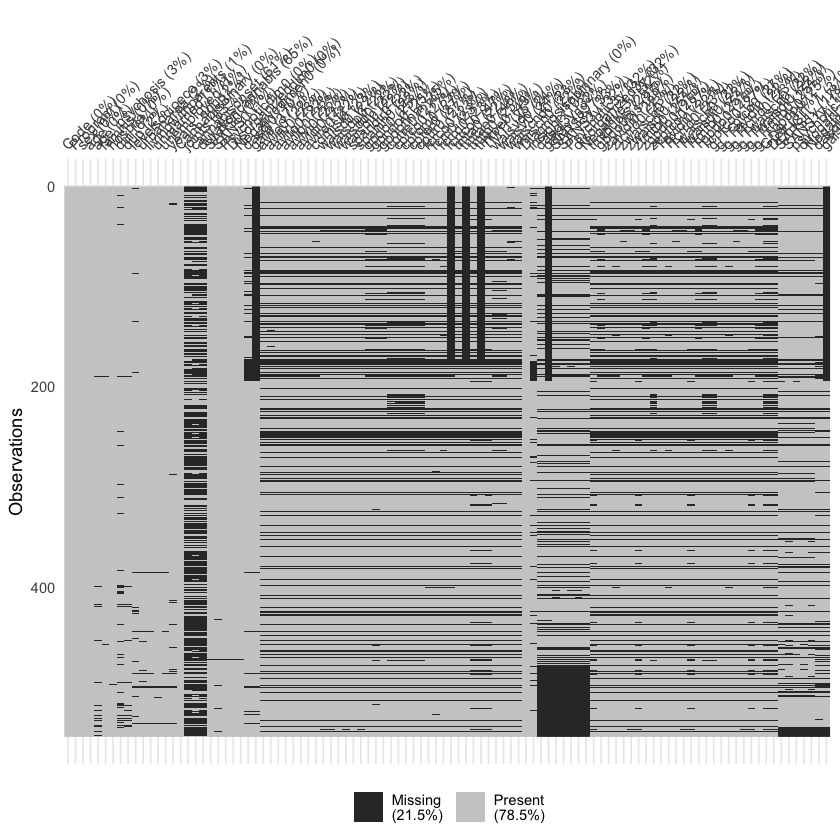

In [23]:
library(visdat)

vis_miss(s1)

A quick visualization of our data show that there are some columns with high completeness, a some columns with larger amounts of missing data. To remedy this, we can remove the columns with large amount of missing data. Let's remove all columns with more than 10% of data missing.

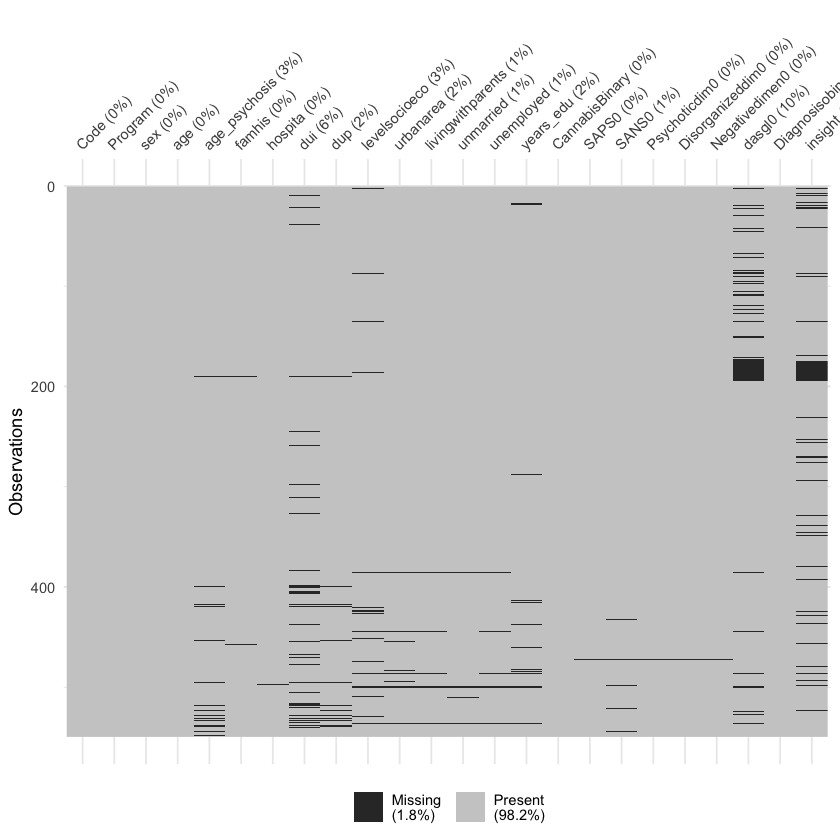

In [136]:
s1 <- s1 %>%
    select(where(~ sum(is.na(.)) < 55))

s2 <- s2 %>%
    select(where(~ sum(is.na(.)) < 48))

s1 %>% vis_miss

Now our data has a much more acceptable amount of missing information, and we have gotten rid of some superfluous fields. 

Next, let's take a look at some of the binary fields. I notice that they seem to use 1 and 2 rather than the standard 0 and 1.

In [44]:
s1 %>% 
    summarise(across(everything(), ~n_distinct(.))) %>% 
    select(where(~ . <= 2))

sex,CannabisBinary,Diagnosisobinnary
<int>,<int>,<int>
2,2,2


In [45]:
s1 %>%
    select(sex, CannabisBinary, Diagnosisobinnary) %>%
    distinct()

sex,CannabisBinary,Diagnosisobinnary
<dbl>,<dbl>,<dbl>
2,2,2
1,2,2
1,2,1
1,1,1
2,1,2
2,2,1
1,1,2
2,1,1


In [137]:
s1 <- s1 %>%
    mutate(
        sex = ifelse(sex == 1, 0, 1),
        CannabisBinary = ifelse(CannabisBinary == 1, 0, 1),
        Diagnosisobinnary = ifelse(Diagnosisobinnary == 1, 0, 1)
    )

We can also visualize the distribution of these binary values. These will demonstrate the sex, cannabis usage, and diagnosis of each participant recorded in the study data.

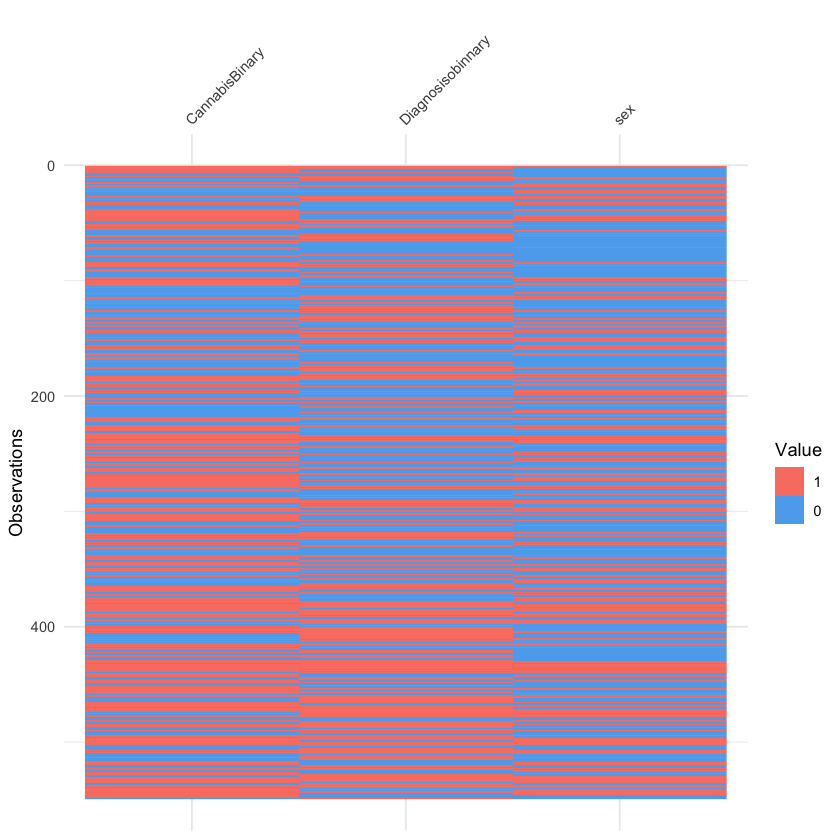

In [138]:
s1 %>%
    select(sex, CannabisBinary, Diagnosisobinnary) %>%
    vis_binary()

In [50]:
s1 %>% write_csv("../data/s1file_clean.csv")

Now that our data from Setién-Suero is relatively clean, let's take a look at another dataset.

## Cannabinoids

We can clean @GIBSON2020113380 data set on cannabinoids and their impact on individuals with psychosis. We will start again by visualizing missing data in our table.

New names:
* `` -> `...1`
* `` -> `...2`


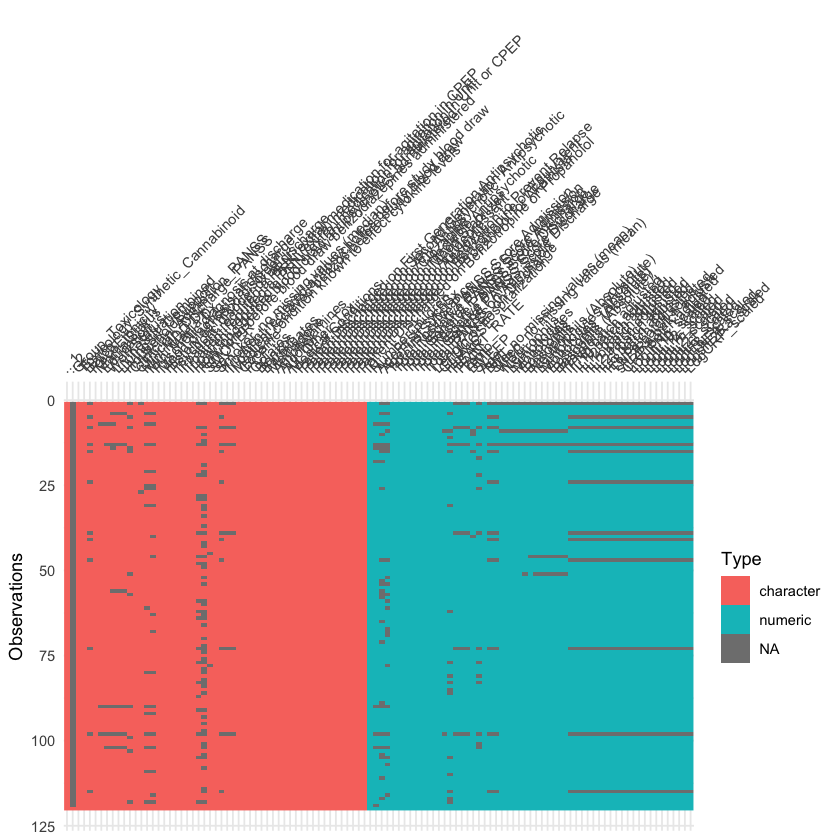

In [63]:
library(readxl)
cannabinoid <- read_excel("../data/raw_data/DataforSumbission_FINAL.xlsx", skip = 1)

cannabinoid %>% vis_dat()

Overall, the completeness of this data is pretty good. We again remove the columns with a high rate of incompleteness. We can also drop rows with missing data because we see a pattern where the missing data tends to collect in rows.

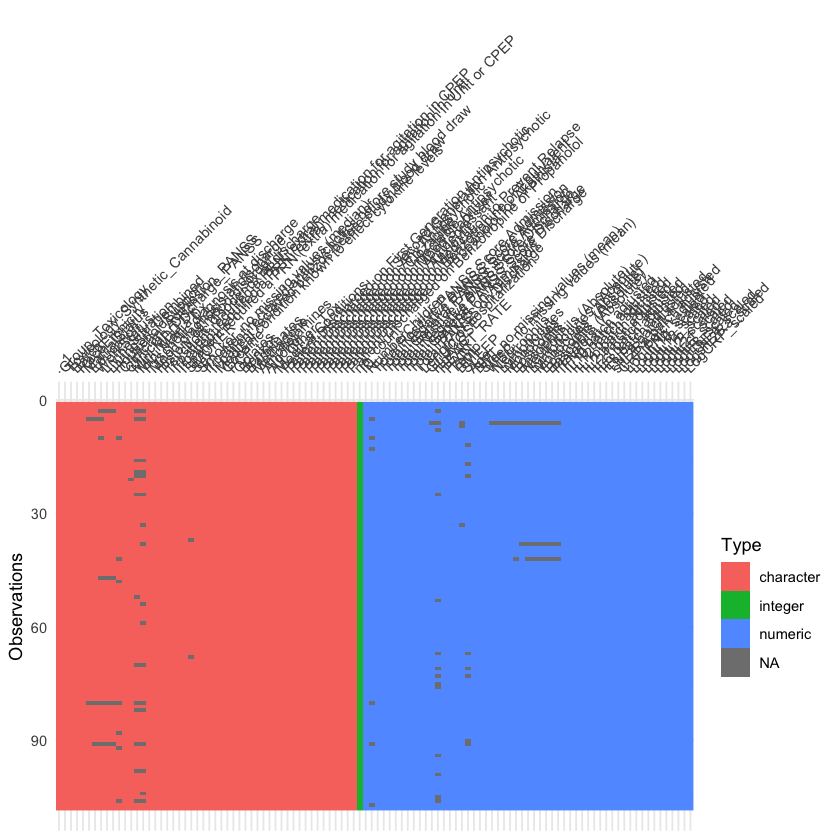

In [96]:
cannabinoid <- cannabinoid %>%
    select(where(~ sum(is.na(.)) < 20))
    
cannabinoid <- cannabinoid %>%
    mutate(na_count = apply(., 1, function(x) sum(is.na(x)))) %>%
    filter(na_count < 20) 
    
cannabinoid %>%
    vis_dat()


I notice that there seem to be a lot of character columns. Let's check to make sure that these columns are standardized and do some cleaning up.

In [102]:
cannabinoid <- cannabinoid %>% select(-`...1`)

In [107]:
name_list <- cannabinoid %>%
    select(where(is.character)) %>%
    names()

In [110]:
for(name in name_list) {
    cannabinoid %>%
        select(all_of(name)) %>% 
        distinct() %>%
        print(n = 10)
}

# A tibble: 3 x 1
  Group_Toxicology    
  <chr>               
1 Cannabinoid-Positive
2 Cannabinoid-Negative
3 119                 
# A tibble: 3 x 1
  Toxicology_Synthetic_Cannabinoid
  <chr>                           
1 Synthetic Cannabinoid Negative  
2 Synthetic Cannabinoid Positive  
3 119                             
# A tibble: 5 x 1
  Batch 
  <chr> 
1 NA    
2 DEC 17
3 MAR 18
4 JUL 18
5 107   
# A tibble: 6 x 1
  RaceEthnicity
  <chr>        
1 Hispanic     
2 Black        
3 White        
4 Asian        
5 Unknown      
6 119          
# A tibble: 6 x 1
  MaritalStatus               
  <chr>                       
1 "Single\u200e/Never married"
2  NA                         
3 "Widowed\u200e/Divorced (?)"
4 "Married"                   
5 "0"                         
6 "116"                       
# A tibble: 6 x 1
  Education               
  <chr>                   
1 Non-high school graduate
2 High school graduate    
3 Some college            
4 College graduate        
5

Generally, these character columns are very clean. However, I want to get rid of the encoding issue causing `\u200e` to appear.

In [127]:
cannabinoid %>%
    filter(if_any(where(is.character), ~str_detect(., "\u200e"))) %>%
    slice_head(n = 1)

ID,Group_Toxicology,Toxicology_Synthetic_Cannabinoid,Batch,RaceEthnicity,MaritalStatus,Education,NumberChildren,WorkStatus,LivingSituation,...,LogIL10_scaled,LogIL12_scaled,LogIL1b_scaled,LogIL2_scaled,LogIL21_scaled,LogIL6_scaled,LogIL8_scaled,LogTNFa_scaled,LogsIL2Ra_scaled,LogCRP_scaled
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,Cannabinoid-Positive,Synthetic Cannabinoid Negative,NA,Hispanic,Single<U+200E>/Never married,Non-high school graduate,0,Not working,Shelter<U+200E>/homeless,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [133]:
cannabinoid <- cannabinoid %>%
    mutate(across(where(is.character), ~str_replace_all(., "\u200e", "")))

cannabinoid %>%
    slice_head(n = 1)

ID,Group_Toxicology,Toxicology_Synthetic_Cannabinoid,Batch,RaceEthnicity,MaritalStatus,Education,NumberChildren,WorkStatus,LivingSituation,...,LogIL10_scaled,LogIL12_scaled,LogIL1b_scaled,LogIL2_scaled,LogIL21_scaled,LogIL6_scaled,LogIL8_scaled,LogTNFa_scaled,LogsIL2Ra_scaled,LogCRP_scaled
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,Cannabinoid-Positive,Synthetic Cannabinoid Negative,NA,Hispanic,Single/Never married,Non-high school graduate,0,Not working,Shelter/homeless,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


 I also notice that there is one row where the values are numeric rather than character. It might be a total row or an error. Let's get rid of that row.

In [112]:
# Confirm that this is only one row
cannabinoid %>%
    filter(Group_Toxicology == 119) %>%
    nrow() %>%
    print()

# Remove the row
cannabinoid <- cannabinoid %>%
    filter(Group_Toxicology != 119)

[1] 1


In [134]:
cannabinoid %>%
    write_csv("../data/cannabinoid_clean.csv")

Now that our data is clean, we can move on to some exploratory data analysis.